# Mounting Google Drive on colab 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [ ]:
import os
import pathlib
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras.utils import losses_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
from keras.callbacks import History 
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from tensorboard.plugins.hparams import api as hp
import kerastuner as kt
print("tensor flow version :: ", tf.version.VERSION)

tensor flow version ::  2.2.0


# File Path for Hyperparameter Tuning

In [5]:
"""data preparation step for hyper parameter tuning
the tuning set will be a sub-sample of the main training set for finding optimal hyperparameters

This is to ensure that the model built using best hyperparameters (returned by keras tuner)
is trained on a different set of images. 
This step will equip the model to work well on unseen data in real time scnearios 
"""

fullDataPath = pathlib.Path("/content/drive/My Drive/OCT2017_tuning dataset")
trainingSet = fullDataPath / 'train'
testingSet = fullDataPath / 'test'
validationSet = fullDataPath / 'val'
trainingSet


PosixPath('/content/drive/My Drive/OCT2017_tuning dataset/train')

# Image Generator and Rescaling

In [6]:
"""ImageDataGenerator generates batches of image data with real-time data augmentation
ImageDataGenerator takes input in batches of 32 by default"""
batch_size = 32
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128


"""Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]"""
train_image_generator_hpTuning = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator_hpTuning = ImageDataGenerator(rescale=1./255) # Generator for our validation data


# Data Import for Hyperparameter Tuning

In [ ]:
"""The flow_from_directory method of ImageDataGenerator class is useful when the images are sorted and 
placed in their respective class/label folders. 
This method will identify classes automatically from the folder name"""
train_data_gen_hpTuning = train_image_generator_hpTuning.flow_from_directory(batch_size=10000,
                                                           directory=trainingSet,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           classes=["DME","CNV","NORMAL","DRUSEN"])
print("total training samples : ", train_data_gen.samples)

Found 6793 images belonging to 4 classes.
total training samples :  6793


In [17]:
#This method will identify classes in the validation dataset, automatically from the folder name"""
val_data_gen_hpTuning = validation_image_generator_hpTuning.flow_from_directory(batch_size=32,
                                                              directory=validationSet,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              classes=["DME","CNV","NORMAL","DRUSEN"])

Found 32 images belonging to 4 classes.


# Visualization

In [10]:
X_train, Y_train = next(train_data_gen_hpTuning)
X_valid, Y_valid = next(val_data_gen_hpTuning)
print(X_train.shape)

(6793, 128, 128, 3)


In [76]:
sample_training_images, _ = next(train_data_gen)

In [77]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

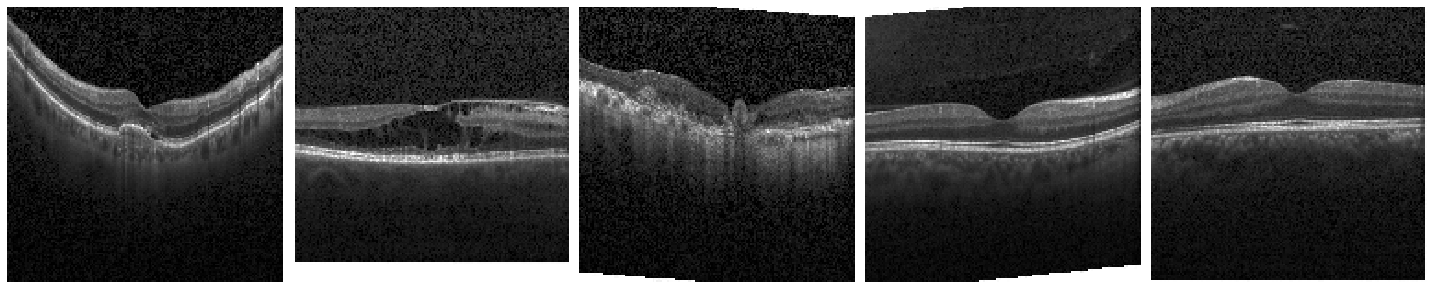

In [78]:
plotImages(sample_training_images[:5])

# Model Definition

In [16]:
#define a model-building function. It takes an hp argument from which we can sample hyperparameters
def build_model(hp):
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = inputs
    #optimizers = hp.Choice('dense_activation',values=['adam', 'sgd'],default='adam')
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):

        filters = hp.Int('filters_' + str(i), 32, 256, step=32)

        activation_layer = hp.Choice('dense_activation',
                                      values=['relu', 'tanh'],
                                      default='relu')
        

        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 5), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            #x = tf.keras.layers.Activation('activation_' + str(i), activation_layer)(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x= tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
          
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    return model


# Keras Tuner Instantiation 

In [17]:
"""Instantiate the tuner
In this example, Keras tuner will use the Hyperband algorithm for the hyperparameter search"""
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy', #the objective that is to be optimized (whether to minimize or maximize is automatically inferred for built-in metrics)
    max_epochs=8,
    hyperband_iterations=2)
 

train_ds, test_ds = train_data_gen_hpTuning, val_data_gen_hpTuning


# Hyperparameter Search

In [18]:
"""the hyperparameter search. To start the search, search method is used. 
This method has the same signature as keras.Model.fit"""
tuner.search(train_data_gen_hpTuning, batch_size=32,
             validation_data=val_data_gen_hpTuning,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])



Epoch 1/3
183/183 [==============================] - 33s 181ms/step - loss: 1.1659 - accuracy: 0.4688 - val_loss: 2.9169 - val_accuracy: 0.2812
Epoch 2/3
183/183 [==============================] - 34s 188ms/step - loss: 0.9206 - accuracy: 0.6187 - val_loss: 2.3043 - val_accuracy: 0.4062
Epoch 3/3
183/183 [==============================] - 36s 196ms/step - loss: 0.7028 - accuracy: 0.7403 - val_loss: 1.5267 - val_accuracy: 0.5312


Epoch 1/3
183/183 [==============================] - 39s 213ms/step - loss: 0.9846 - accuracy: 0.5666 - val_loss: 11.7430 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 39s 213ms/step - loss: 0.6942 - accuracy: 0.7316 - val_loss: 2.8430 - val_accuracy: 0.4062
Epoch 3/3
183/183 [==============================] - 39s 213ms/step - loss: 0.5474 - accuracy: 0.7985 - val_loss: 1.8142 - val_accuracy: 0.4688


Epoch 1/3
183/183 [==============================] - 84s 460ms/step - loss: 0.9296 - accuracy: 0.6119 - val_loss: 1.8584 - val_accuracy: 0.2188
Epoch 2/3
183/183 [==============================] - 84s 458ms/step - loss: 0.4958 - accuracy: 0.8163 - val_loss: 3.2553 - val_accuracy: 0.4062


Epoch 1/3
183/183 [==============================] - 113s 619ms/step - loss: 1.0388 - accuracy: 0.5468 - val_loss: 11.7605 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 114s 621ms/step - loss: 0.7244 - accuracy: 0.7217 - val_loss: 5.7644 - val_accuracy: 0.2812
Epoch 3/3
183/183 [==============================] - 113s 619ms/step - loss: 0.5534 - accuracy: 0.7913 - val_loss: 8.1668 - val_accuracy: 0.2500


Epoch 1/3
183/183 [==============================] - 88s 482ms/step - loss: 1.0828 - accuracy: 0.5140 - val_loss: 5.7825 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 88s 481ms/step - loss: 0.8434 - accuracy: 0.6492 - val_loss: 8.5168 - val_accuracy: 0.2500


Epoch 4/8
183/183 [==============================] - 36s 195ms/step - loss: 1.1760 - accuracy: 0.4604 - val_loss: 3.5916 - val_accuracy: 0.2500
Epoch 5/8
183/183 [==============================] - 35s 193ms/step - loss: 0.8705 - accuracy: 0.6469 - val_loss: 3.3004 - val_accuracy: 0.2500
Epoch 6/8
183/183 [==============================] - 35s 193ms/step - loss: 0.6706 - accuracy: 0.7546 - val_loss: 1.8377 - val_accuracy: 0.2500
Epoch 7/8
183/183 [==============================] - 35s 194ms/step - loss: 0.5741 - accuracy: 0.7958 - val_loss: 0.2857 - val_accuracy: 0.9062
Epoch 8/8
183/183 [==============================] - 35s 193ms/step - loss: 0.4805 - accuracy: 0.8258 - val_loss: 0.3755 - val_accuracy: 0.9062


Epoch 4/8
183/183 [==============================] - 39s 214ms/step - loss: 0.9974 - accuracy: 0.5606 - val_loss: 3.4554 - val_accuracy: 0.2188
Epoch 5/8
183/183 [==============================] - 39s 214ms/step - loss: 0.6705 - accuracy: 0.7440 - val_loss: 3.2436 - val_accuracy: 0.2500
Epoch 6/8
183/183 [==============================] - 39s 214ms/step - loss: 0.5030 - accuracy: 0.8134 - val_loss: 3.8774 - val_accuracy: 0.3125


Epoch 1/8
183/183 [==============================] - 66s 361ms/step - loss: 0.8286 - accuracy: 0.6663 - val_loss: 8.8789 - val_accuracy: 0.2500
Epoch 2/8
183/183 [==============================] - 66s 359ms/step - loss: 0.4762 - accuracy: 0.8214 - val_loss: 4.8975 - val_accuracy: 0.3750
Epoch 3/8
183/183 [==============================] - 66s 361ms/step - loss: 0.4059 - accuracy: 0.8499 - val_loss: 3.9598 - val_accuracy: 0.2500
Epoch 4/8
183/183 [==============================] - 66s 361ms/step - loss: 0.3365 - accuracy: 0.8769 - val_loss: 0.4181 - val_accuracy: 0.8125
Epoch 5/8
183/183 [==============================] - 66s 362ms/step - loss: 0.2957 - accuracy: 0.8933 - val_loss: 0.3996 - val_accuracy: 0.9062
Epoch 6/8
183/183 [==============================] - 66s 362ms/step - loss: 0.2903 - accuracy: 0.8953 - val_loss: 0.1815 - val_accuracy: 0.9062
Epoch 7/8
183/183 [==============================] - 66s 362ms/step - loss: 0.2487 - accuracy: 0.9124 - val_loss: 1.6040 - val_accuracy:

Epoch 1/8
183/183 [==============================] - 104s 570ms/step - loss: 1.0706 - accuracy: 0.5200 - val_loss: 3.2846 - val_accuracy: 0.2812
Epoch 2/8
183/183 [==============================] - 104s 569ms/step - loss: 0.8461 - accuracy: 0.6518 - val_loss: 14.4952 - val_accuracy: 0.2500


Epoch 1/8
183/183 [==============================] - 66s 361ms/step - loss: 1.1934 - accuracy: 0.4428 - val_loss: 9.1384 - val_accuracy: 0.2500
Epoch 2/8
183/183 [==============================] - 66s 360ms/step - loss: 0.8938 - accuracy: 0.6269 - val_loss: 2.2221 - val_accuracy: 0.3125
Epoch 3/8
183/183 [==============================] - 66s 360ms/step - loss: 0.6566 - accuracy: 0.7594 - val_loss: 2.9692 - val_accuracy: 0.4062


Epoch 1/3
183/183 [==============================] - 16s 88ms/step - loss: 0.9749 - accuracy: 0.5879 - val_loss: 24.1366 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 16s 87ms/step - loss: 0.6370 - accuracy: 0.7657 - val_loss: 18.7415 - val_accuracy: 0.2500
Epoch 3/3
183/183 [==============================] - 16s 87ms/step - loss: 0.5222 - accuracy: 0.8140 - val_loss: 2.4443 - val_accuracy: 0.5312


Epoch 1/3
183/183 [==============================] - 37s 203ms/step - loss: 0.8144 - accuracy: 0.6621 - val_loss: 3.1322 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 37s 202ms/step - loss: 0.4207 - accuracy: 0.8473 - val_loss: 3.0181 - val_accuracy: 0.2500
Epoch 3/3
183/183 [==============================] - 37s 202ms/step - loss: 0.3354 - accuracy: 0.8822 - val_loss: 0.1042 - val_accuracy: 1.0000


Epoch 1/3
183/183 [==============================] - 70s 381ms/step - loss: 0.9892 - accuracy: 0.5640 - val_loss: 7.5382 - val_accuracy: 0.3438
Epoch 2/3
183/183 [==============================] - 69s 380ms/step - loss: 0.6973 - accuracy: 0.7287 - val_loss: 3.8571 - val_accuracy: 0.2812
Epoch 3/3
183/183 [==============================] - 70s 381ms/step - loss: 0.5251 - accuracy: 0.7994 - val_loss: 1.3630 - val_accuracy: 0.5625


Epoch 1/3
183/183 [==============================] - 47s 258ms/step - loss: 0.8090 - accuracy: 0.6728 - val_loss: 5.4500 - val_accuracy: 0.4688
Epoch 2/3
183/183 [==============================] - 47s 257ms/step - loss: 0.4897 - accuracy: 0.8216 - val_loss: 4.7820 - val_accuracy: 0.2500
Epoch 3/3
183/183 [==============================] - 47s 257ms/step - loss: 0.3801 - accuracy: 0.8595 - val_loss: 0.8151 - val_accuracy: 0.6875


Epoch 1/3
183/183 [==============================] - 76s 418ms/step - loss: 1.1106 - accuracy: 0.4957 - val_loss: 7.0841 - val_accuracy: 0.2500
Epoch 2/3
183/183 [==============================] - 76s 416ms/step - loss: 0.7746 - accuracy: 0.6872 - val_loss: 4.4506 - val_accuracy: 0.4062
Epoch 3/3
183/183 [==============================] - 77s 418ms/step - loss: 0.5434 - accuracy: 0.7973 - val_loss: 1.9664 - val_accuracy: 0.5312


Epoch 4/8
183/183 [==============================] - 37s 203ms/step - loss: 0.8935 - accuracy: 0.6260 - val_loss: 2.9037 - val_accuracy: 0.2500
Epoch 5/8
183/183 [==============================] - 37s 202ms/step - loss: 0.4740 - accuracy: 0.8337 - val_loss: 2.5708 - val_accuracy: 0.2500
Epoch 6/8
183/183 [==============================] - 37s 202ms/step - loss: 0.3556 - accuracy: 0.8733 - val_loss: 0.7148 - val_accuracy: 0.6875
Epoch 7/8
183/183 [==============================] - 37s 202ms/step - loss: 0.3009 - accuracy: 0.8957 - val_loss: 0.8038 - val_accuracy: 0.7500


Epoch 4/8
183/183 [==============================] - 47s 258ms/step - loss: 0.8280 - accuracy: 0.6598 - val_loss: 7.0881 - val_accuracy: 0.2500
Epoch 5/8
183/183 [==============================] - 47s 257ms/step - loss: 0.4899 - accuracy: 0.8202 - val_loss: 2.4652 - val_accuracy: 0.4062
Epoch 6/8
183/183 [==============================] - 47s 257ms/step - loss: 0.3965 - accuracy: 0.8538 - val_loss: 1.4354 - val_accuracy: 0.6250
Epoch 7/8
183/183 [==============================] - 47s 257ms/step - loss: 0.2995 - accuracy: 0.8934 - val_loss: 0.2078 - val_accuracy: 0.9062
Epoch 8/8
183/183 [==============================] - 47s 257ms/step - loss: 0.2798 - accuracy: 0.9018 - val_loss: 0.1581 - val_accuracy: 0.9375


Epoch 1/8
183/183 [==============================] - 39s 211ms/step - loss: 1.0945 - accuracy: 0.5099 - val_loss: 10.7894 - val_accuracy: 0.2500
Epoch 2/8
183/183 [==============================] - 38s 209ms/step - loss: 0.7522 - accuracy: 0.7047 - val_loss: 3.0791 - val_accuracy: 0.3125
Epoch 3/8
183/183 [==============================] - 38s 210ms/step - loss: 0.5747 - accuracy: 0.7775 - val_loss: 1.8453 - val_accuracy: 0.5938
Epoch 4/8
183/183 [==============================] - 38s 209ms/step - loss: 0.4573 - accuracy: 0.8229 - val_loss: 4.6355 - val_accuracy: 0.2500


Epoch 1/8
183/183 [==============================] - 38s 207ms/step - loss: 1.2345 - accuracy: 0.3999 - val_loss: 38.8857 - val_accuracy: 0.2500
Epoch 2/8
183/183 [==============================] - 38s 206ms/step - loss: 0.9870 - accuracy: 0.5509 - val_loss: 44.4474 - val_accuracy: 0.2500


Epoch 1/8
183/183 [==============================] - 41s 226ms/step - loss: 1.0852 - accuracy: 0.5227 - val_loss: 2.0533 - val_accuracy: 0.2500
Epoch 2/8
183/183 [==============================] - 41s 225ms/step - loss: 0.7085 - accuracy: 0.7421 - val_loss: 2.9238 - val_accuracy: 0.2812


INFO:tensorflow:Oracle triggered exit


# Loading Best Model

In [19]:
"""Each model will train for at most 8 epochs, and two iterations of the Hyperband algorithm will be run. 
Afterwards, the best models found during the search can be retrieved using the get_best_models function"""

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# the optimal hyperparameter values found by the search
print("best hyperparameters are: ", best_hyperparameters)

best hyperparameters are:  <kerastuner.engine.hyperparameters.HyperParameters object at 0x7fafce790828>


In [20]:
# the model is built using the optimal hyperparameter values found by the search
model = tuner.hypermodel.build(best_hyperparameters)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 96)      4416      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 96)      384       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 96)      138336    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 96)      384       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 96)      0     

In [23]:
model.save('OCT_model_colab.h5') 

# File Path for Training Dataset

In [3]:
"""data preparation step for model training
the training set is a different set of images, than that was used for finding optimal hyperparameters

This is to ensure that the model built using best hyperparameters (returned by keras tuner) 
is trained on a different set of images. 
This step will equip the model to work well on unseen data in real time scnearios 
"""
fullDataPath = pathlib.Path("C://StudyNCI//Lectures//Machine Learning 2//OCT2017 - ModelTesting")
trainingSet = fullDataPath / 'train'
testingSet = fullDataPath / 'test'
validationSet = fullDataPath / 'val'

trainingSet

WindowsPath('C:/StudyNCI/Lectures/Machine Learning 2/OCT2017 - ModelTesting/train')

# Imagegenerators for Training, Testing and Validation

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=testingSet,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size=32,
                                                  classes=["DME","CNV","NORMAL","DRUSEN"])
print("total testing samples : ", test_generator.samples)

Found 1000 images belonging to 4 classes.
total testing samples :  1000


In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_directory(batch_size=80000,
                                                           directory=trainingSet,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           classes=["DME","CNV","NORMAL","DRUSEN"])
print("total training samples : ", train_data_gen.samples)

Found 76716 images belonging to 4 classes.
total training samples :  76716


In [7]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

val_data_gen = validation_image_generator.flow_from_directory(batch_size=32,
                                                              directory=validationSet,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              classes=["DME","CNV","NORMAL","DRUSEN"])
print("total validation samples : ", val_data_gen.samples)

Found 32 images belonging to 4 classes.
total validation samples :  32


In [8]:
X_train, Y_train = next(train_data_gen)
X_test, Y_test = next(test_generator)
print(X_train.shape)

(76716, 128, 128, 3)


# Class Imbalance Handler

In [9]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

# Make Data 1-Dimensional for compatability with under-sampling methods
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
# for example: X_trainShape (27072, 128, 128, 3) will be reshaped to X_trainFlat(27072,49152)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

"""Random undersampling involves randomly selecting examples from the majority class 
to delete from the training dataset."""

#initialize under sampler
ros = RandomUnderSampler()    
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Restore the 1-D undersampled training data to its previous state using image height, image weight and channel info
for i in range(len(X_trainRos)):
    height, width, channels = IMG_HEIGHT,IMG_WIDTH,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)

# Restore the 1-D undersampled validation data to its previous state using image height, image weight and channel info
for i in range(len(X_testRos)):
    height, width, channels = IMG_HEIGHT,IMG_WIDTH,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)

print(X_trainRosReshaped.shape)    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(27072, 128, 128, 3)


# Checkpoints

In [5]:
checkpoint_dir = fullDataPath /'checkpoints'
# Name of the checkpoint files
checkpoint_file = os.path.join(checkpoint_dir, "ckpt_{epoch}.ckpt")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    save_freq=3)

In [6]:
new_model = tf.keras.models.load_model('C://StudyNCI//Lectures//Machine Learning 2//OCT_model_colab.h5')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 96)      4416      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 96)      384       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 96)      138336    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 96)      384       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 96)      0     

# Model Training

In [15]:
history = new_model.fit(X_trainRosReshaped,Y_trainRos, 
    steps_per_epoch=X_trainRosReshaped.shape[0] // batch_size,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[checkpoint_callback])

Epoch 1/5
170/846 [=====>........................] - ETA: 0s - loss: 2.2620 - accuracy: 0.18 - ETA: 1:05:39 - loss: 2.3053 - accuracy: 0.218 - ETA: 1:31:27 - loss: 2.0729 - accuracy: 0.260 - ETA: 1:44:07 - loss: 1.9296 - accuracy: 0.265 - ETA: 1:53:14 - loss: 1.8559 - accuracy: 0.256 - ETA: 1:59:42 - loss: 1.7823 - accuracy: 0.260 - ETA: 2:05:44 - loss: 1.7326 - accuracy: 0.263 - ETA: 2:13:01 - loss: 1.6989 - accuracy: 0.265 - ETA: 2:19:14 - loss: 1.6879 - accuracy: 0.260 - ETA: 2:22:04 - loss: 1.6716 - accuracy: 0.256 - ETA: 2:23:21 - loss: 1.6608 - accuracy: 0.255 - ETA: 2:24:43 - loss: 1.6481 - accuracy: 0.260 - ETA: 2:25:48 - loss: 1.6343 - accuracy: 0.262 - ETA: 2:27:28 - loss: 1.6442 - accuracy: 0.261 - ETA: 2:30:00 - loss: 1.6248 - accuracy: 0.262 - ETA: 2:30:22 - loss: 1.6183 - accuracy: 0.265 - ETA: 2:30:41 - loss: 1.6005 - accuracy: 0.273 - ETA: 2:31:17 - loss: 1.6012 - accuracy: 0.276 - ETA: 2:31:39 - loss: 1.5962 - accuracy: 0.273 - ETA: 2:31:58 - loss: 1.5846 - accuracy: 0

170/846 [=====>........................] - ETA: 0s - loss: 0.4464 - accuracy: 0.81 - ETA: 1:50:41 - loss: 0.4225 - accuracy: 0.828 - ETA: 2:18:19 - loss: 0.4234 - accuracy: 0.843 - ETA: 2:30:07 - loss: 0.4374 - accuracy: 0.851 - ETA: 2:38:16 - loss: 0.4505 - accuracy: 0.850 - ETA: 2:44:35 - loss: 0.4389 - accuracy: 0.849 - ETA: 2:50:36 - loss: 0.4380 - accuracy: 0.848 - ETA: 2:52:22 - loss: 0.4392 - accuracy: 0.847 - ETA: 2:53:22 - loss: 0.4069 - accuracy: 0.861 - ETA: 2:53:36 - loss: 0.3928 - accuracy: 0.862 - ETA: 2:56:08 - loss: 0.3962 - accuracy: 0.858 - ETA: 2:58:46 - loss: 0.3775 - accuracy: 0.864 - ETA: 2:58:56 - loss: 0.3728 - accuracy: 0.863 - ETA: 3:00:19 - loss: 0.3622 - accuracy: 0.868 - ETA: 3:00:08 - loss: 0.3592 - accuracy: 0.868 - ETA: 2:59:36 - loss: 0.3639 - accuracy: 0.867 - ETA: 2:59:19 - loss: 0.3727 - accuracy: 0.860 - ETA: 2:59:03 - loss: 0.3716 - accuracy: 0.862 - ETA: 2:58:53 - loss: 0.3670 - accuracy: 0.863 - ETA: 2:58:31 - loss: 0.3680 - accuracy: 0.864 - ETA

846/846 [==============================] - ETA: 29:39 - loss: 0.3806 - accuracy: 0.862 - ETA: 29:28 - loss: 0.3810 - accuracy: 0.861 - ETA: 29:17 - loss: 0.3809 - accuracy: 0.861 - ETA: 29:05 - loss: 0.3808 - accuracy: 0.861 - ETA: 28:54 - loss: 0.3806 - accuracy: 0.861 - ETA: 28:43 - loss: 0.3808 - accuracy: 0.861 - ETA: 28:31 - loss: 0.3805 - accuracy: 0.862 - ETA: 28:20 - loss: 0.3807 - accuracy: 0.862 - ETA: 28:08 - loss: 0.3804 - accuracy: 0.862 - ETA: 27:57 - loss: 0.3807 - accuracy: 0.862 - ETA: 27:46 - loss: 0.3807 - accuracy: 0.862 - ETA: 27:34 - loss: 0.3806 - accuracy: 0.862 - ETA: 27:23 - loss: 0.3806 - accuracy: 0.862 - ETA: 27:12 - loss: 0.3806 - accuracy: 0.862 - ETA: 27:00 - loss: 0.3806 - accuracy: 0.862 - ETA: 26:49 - loss: 0.3809 - accuracy: 0.861 - ETA: 26:38 - loss: 0.3809 - accuracy: 0.861 - ETA: 26:26 - loss: 0.3809 - accuracy: 0.862 - ETA: 26:15 - loss: 0.3812 - accuracy: 0.861 - ETA: 26:03 - loss: 0.3809 - accuracy: 0.862 - ETA: 25:52 - loss: 0.3806 - accuracy:

170/846 [=====>........................] - ETA: 0s - loss: 0.3148 - accuracy: 0.87 - ETA: 1:43:08 - loss: 0.1846 - accuracy: 0.937 - ETA: 2:14:20 - loss: 0.3007 - accuracy: 0.895 - ETA: 2:28:28 - loss: 0.3040 - accuracy: 0.898 - ETA: 2:36:50 - loss: 0.2932 - accuracy: 0.887 - ETA: 2:42:50 - loss: 0.3239 - accuracy: 0.875 - ETA: 2:46:39 - loss: 0.3156 - accuracy: 0.875 - ETA: 2:49:01 - loss: 0.3203 - accuracy: 0.867 - ETA: 2:51:55 - loss: 0.3352 - accuracy: 0.861 - ETA: 2:55:32 - loss: 0.3181 - accuracy: 0.871 - ETA: 2:56:39 - loss: 0.3111 - accuracy: 0.875 - ETA: 2:57:51 - loss: 0.3027 - accuracy: 0.880 - ETA: 2:58:27 - loss: 0.2978 - accuracy: 0.882 - ETA: 2:58:52 - loss: 0.2945 - accuracy: 0.886 - ETA: 2:59:32 - loss: 0.2885 - accuracy: 0.889 - ETA: 2:59:44 - loss: 0.2791 - accuracy: 0.894 - ETA: 2:59:47 - loss: 0.2871 - accuracy: 0.889 - ETA: 3:00:04 - loss: 0.2957 - accuracy: 0.885 - ETA: 3:00:33 - loss: 0.2870 - accuracy: 0.889 - ETA: 3:00:30 - loss: 0.2850 - accuracy: 0.890 - ETA

846/846 [==============================] - ETA: 31:18 - loss: 0.2614 - accuracy: 0.906 - ETA: 31:06 - loss: 0.2614 - accuracy: 0.906 - ETA: 30:54 - loss: 0.2614 - accuracy: 0.906 - ETA: 30:42 - loss: 0.2613 - accuracy: 0.906 - ETA: 30:30 - loss: 0.2612 - accuracy: 0.906 - ETA: 30:18 - loss: 0.2611 - accuracy: 0.906 - ETA: 30:06 - loss: 0.2612 - accuracy: 0.906 - ETA: 29:54 - loss: 0.2615 - accuracy: 0.906 - ETA: 29:42 - loss: 0.2613 - accuracy: 0.906 - ETA: 29:30 - loss: 0.2612 - accuracy: 0.906 - ETA: 29:18 - loss: 0.2609 - accuracy: 0.906 - ETA: 29:06 - loss: 0.2610 - accuracy: 0.906 - ETA: 28:54 - loss: 0.2612 - accuracy: 0.906 - ETA: 28:42 - loss: 0.2612 - accuracy: 0.906 - ETA: 28:30 - loss: 0.2612 - accuracy: 0.906 - ETA: 28:18 - loss: 0.2615 - accuracy: 0.906 - ETA: 28:06 - loss: 0.2613 - accuracy: 0.906 - ETA: 27:54 - loss: 0.2614 - accuracy: 0.906 - ETA: 27:42 - loss: 0.2616 - accuracy: 0.906 - ETA: 27:30 - loss: 0.2616 - accuracy: 0.906 - ETA: 27:18 - loss: 0.2614 - accuracy:

In [84]:
model.save('OCT_model_trained.h5') 

# Accuracy and Loss Graph

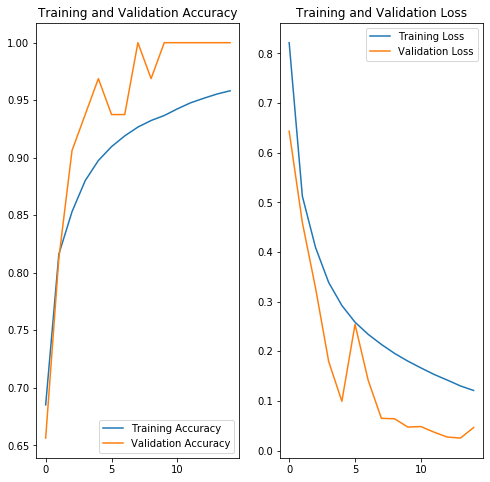

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
new_model = tf.keras.models.load_model('C://StudyNCI//Lectures//Machine Learning 2//OCT_model_trained.h5')
latest = tf.train.latest_checkpoint(checkpoint_dir)
#new_model.load_weights(checkpoint_dir / 'ckpt_5.data-00000-of-00001.hdf5')
new_model.load_weights(latest)

# Model Validation on Test Dataset

In [8]:
loss, acc = new_model.evaluate(test_generator, verbose=2, steps = test_generator.samples // batch_size)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

31/31 - 68s - loss: 0.0659 - accuracy: 0.9768
Restored model, accuracy: 97.68%


In [21]:
X_test, Y_test = next(test_generator)
y_pred = new_model.predict(X_test)


In [10]:
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

In [11]:
actual_class = []
for i in range(len(Y_test)):
    actual_class.append(np.argmax(Y_test[i]))

In [12]:
print(' Test accuracy = ',accuracy_score(pred_class,actual_class))

 Test accuracy =  0.96875


# Confusion Matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

--------------------
| Confusion Matrix |
--------------------

 [[ 4  0  0  0]
 [ 0  8  0  0]
 [ 0  0  9  0]
 [ 0  1  0 10]]


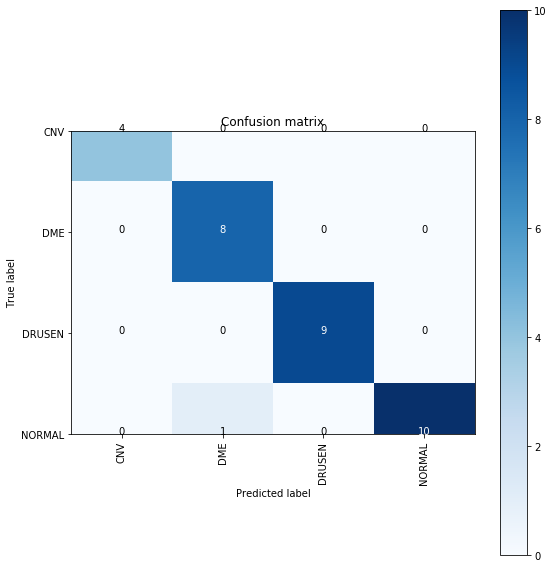

In [18]:
cm = confusion_matrix(actual_class, pred_class)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(actual_class, pred_class,target_names=['CNV','DME','DRUSEN','Normal']))

              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00         4
         DME       0.89      1.00      0.94         8
      DRUSEN       1.00      1.00      1.00         9
      Normal       1.00      0.91      0.95        11

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.97      0.97      0.97        32



# Model Evaluation

In [19]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall/TPR = {}".format(TPR))

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity/TNR = {}".format(TNR))

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision/PPV = {}".format(PPV))

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predict Value = {}".format(NPV))

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate = {}".format(FPR))

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate = {}".format(FNR))

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate = {}".format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy = {}".format(ACC))

Recall/TPR = [1.         1.         1.         0.90909091]
Specificity/TNR = [1.         0.95833333 1.         1.        ]
Precision/PPV = [1.         0.88888889 1.         1.        ]
Negative Predict Value = [1.         1.         1.         0.95454545]
False Positive Rate = [0.         0.04166667 0.         0.        ]
False Negative Rate = [0.         0.         0.         0.09090909]
False discovery rate = [0.         0.11111111 0.         0.        ]
Overall Accuracy = [1.      0.96875 1.      0.96875]
